# Accelerated Portrait Creator

**SageMaker Studio Kernel**: Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)  
**Instance**: ml.t3.medium


In [ ]:
import os
import boto3
import sagemaker

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

sess = sagemaker.session.Session()
region = sess.boto_region_name

print(f"sagemaker role arn: {role}")
print(f"sagemaker session region: {region}")

In [ ]:
sd_endpoint_name="<<YOUR_ENDPOINT_1_HERE>>"
sd_inpaint_endpoint_name="<<YOUR_ENDPOINT_2_HERE>>"
unet_bgrm_endpoint_name="<<YOUR_ENDPOINT_3_HERE>>"

In [ ]:
import cv2
import numpy as np
from sagemaker.serializers import JSONSerializer, DataSerializer
from sagemaker.deserializers import BytesDeserializer

sd_predictor = sagemaker.Predictor(endpoint_name=sd_endpoint_name)
sd_predictor.serializer = JSONSerializer()
sd_predictor.deserializer = BytesDeserializer(accept='image/jpeg')

sd_inpaint_predictor = sagemaker.Predictor(endpoint_name=sd_inpaint_endpoint_name)
sd_inpaint_predictor.serializer = JSONSerializer()
sd_inpaint_predictor.deserializer = BytesDeserializer(accept='image/jpeg')

unet_bgrm_predictor = sagemaker.Predictor(endpoint_name=unet_bgrm_endpoint_name)
unet_bgrm_predictor.serializer = DataSerializer(content_type='image/jpeg')
unet_bgrm_predictor.deserializer = BytesDeserializer(accept='image/png')

### Generate non-existing person picture

In [ ]:
%%time
prompt="high quality, face portrait photo of 30 y.o woman, wearing black shirt, smiling, detailed face, skin pores, cinematic shot, empty background"
negative_prompt="(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), nude, text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"

input_req={
    "prompt": prompt,
    "negative_prompt": negative_prompt,
    # more info about these 2 params here: https://huggingface.co/blog/stable_diffusion
    "num_inference_steps": 150, # 150 is ideal for a better quality
}

data = sd_predictor.predict(input_req)
open('portrait.jpg', 'wb').write(data)

### Remove background

In [ ]:
mask = unet_bgrm_predictor.predict(data)
img = np.frombuffer(mask, dtype=np.uint8)
img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (896,896))
cv2.imwrite('portrait_mask.png', img)

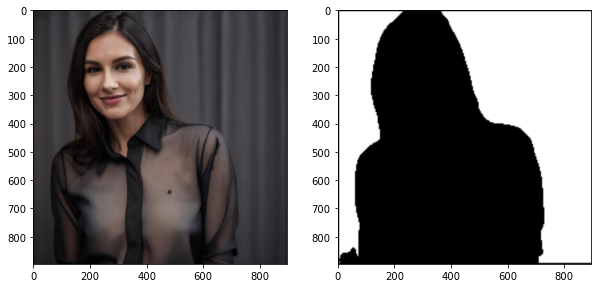

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
rows,cols=1,2
fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(cv2.imread('portrait.jpg'), cv2.COLOR_BGR2RGB))
fig.add_subplot(rows, cols, 2)
plt.imshow(cv2.cvtColor(cv2.imread('portrait_mask.png'), cv2.COLOR_BGR2RGB))
plt.show()

### Add different backgrounds

In [39]:
import base64
input_req['image'] = base64.b64encode(open('portrait.jpg', 'rb').read()).decode('utf-8')
input_req['mask_image'] = base64.b64encode(open('portrait_mask.png', 'rb').read()).decode('utf-8')
input_req['num_inference_steps'] = 100

In [40]:
import os
def create_picture(prompt):
    input_req['prompt'] = prompt

    data = sd_inpaint_predictor.predict(input_req)
    for i in range(100):
        pic_name = f'picture{i}.jpg'
        if not os.path.isfile(pic_name): break
    open(pic_name, 'wb').write(data)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(cv2.imread(pic_name), cv2.COLOR_BGR2RGB))

CPU times: user 43.9 ms, sys: 7.5 ms, total: 51.4 ms
Wall time: 22.6 s


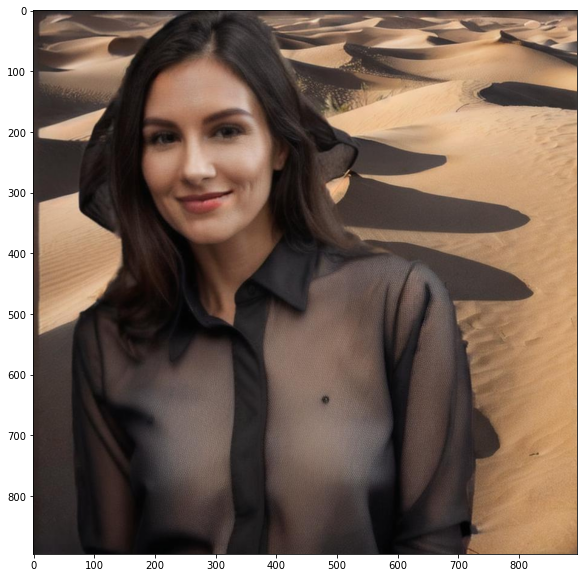

In [41]:
%%time
create_picture("high quality, desert with dunes")

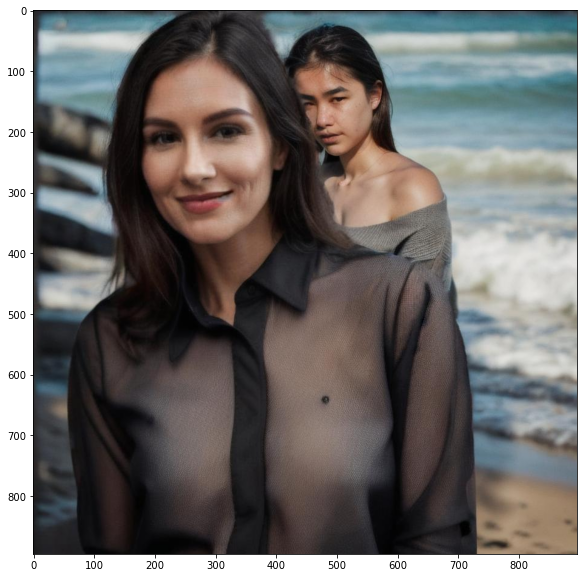

In [42]:
create_picture("RAW photo, subject, 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3, beach")

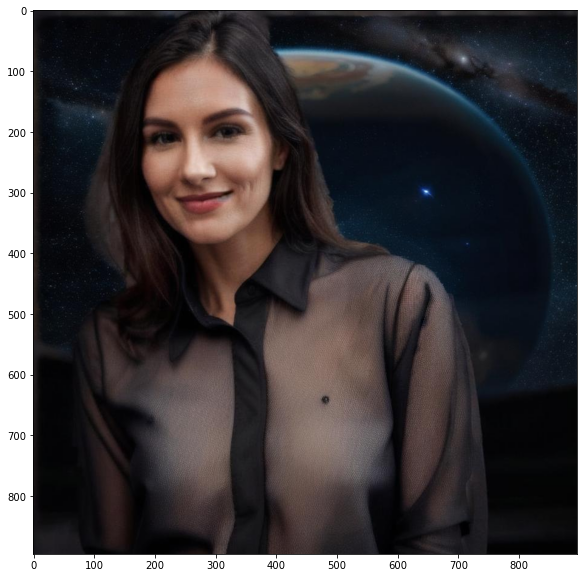

In [43]:
create_picture("high quality, cinematic shot, space with planets and nebulous")